In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import torchmetrics.functional as metrics
import os
import shutil
from torchvision import transforms
from PIL import Image

c:\Users\kdp\.conda\envs\TORCH_PY38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 학습 검증용 데이터
folder_path = 'data/train/train'
target_data = []
img_data = []
for encoding_label,label in enumerate(os.listdir(folder_path)):
    for img in os.listdir(folder_path+'/'+label):
        image_path = os.path.join(folder_path,label,img)
        with open(image_path, 'rb') as file:
            image = Image.open(file)
            # 이미지 크기 확인
            width, height = image.size
            if width == 48 and height == 48:
                image_array = np.array(image)
                
                target_data.append(encoding_label)
                img_data.append(image_array)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'data/train/train'

In [ ]:
# 테스트용 데이터
folder_path_ = 'data/test/test'
target_test = []
img_test = []
for encoding_label,label in enumerate(os.listdir(folder_path_)):
    for img in os.listdir(folder_path_+'/'+label):
        image_path = os.path.join(folder_path_,label,img)
        with open(image_path, 'rb') as file:
            image = Image.open(file)
            if width == 48 and height == 48:
                image_array = np.array(image)
                target_test.append(encoding_label)
                img_test.append(image_array)

In [ ]:
pd.Series(target_test).value_counts().sort_index()

0    3995
1     436
2    4097
3    7215
4    4965
5    4830
6    3171
Name: count, dtype: int64

In [ ]:
os.listdir(folder_path)
# 1:angry / 2:disgust / 3:fear / 4:happy / 5:neutral / 6:sad / 7:surprise

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
pd.Series(target_data).value_counts().sort_index()

0    3995
1     436
2    4097
3    7215
4    4965
5    4830
6    3171
Name: count, dtype: int64

In [ ]:
image = Image.open("data/test/test/angry/PrivateTest_1488292.jpg")

# 이미지의 너비와 높이 확인
width, height = image.size
print("이미지의 너비:", width)
print("이미지의 높이:", height)

# 이미지 크기 48 * 48

이미지의 너비: 48
이미지의 높이: 48


In [ ]:
# 이미지 데이터 정규화
x_data = np.array(img_data)/255.
x_data = x_data.reshape((-1,48*48))
print(x_data.shape)

(28709, 2304)


In [ ]:
# 원핫 인코딩
# from sklearn.preprocessing import OneHotEncoder
# y_data = OneHotEncoder(sparse_output=False).fit_transform(np.array(target_data).reshape(-1,1))

In [ ]:
# 데이터 클래스 생성
import random
class DLdataset(Dataset):
    
    def __init__(self,x_data,y_data):
        super().__init__()
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.LongTensor(y_data)
        
    def __len__(self):
        return self.target.shape[0]
    
    def __getitem__(self,idx):
        return self.feature[idx], self.target[idx]

In [ ]:
# 데이터셋 생성
dataset = DLdataset(x_data,target_data)

In [ ]:
# 학습용, 검증용 데이터 준비
seed = torch.Generator().manual_seed(42)
trainDS, validDS = random_split(dataset, [0.8,0.2], generator=seed)

In [ ]:
# 배치사이즈 32
BATCH = 32
trainDL = DataLoader(trainDS, batch_size=BATCH)
validDL = DataLoader(validDS, batch_size=BATCH)

In [ ]:
# 모델 클래스 정의
class Model(nn.Module):
    
    def __init__(self, IN, OUT, AF):
        super().__init__()
        self.input = nn.Linear(IN, 128) 
        self.af = AF()
        self.hidden = nn.Linear(128, 32)
        self.output = nn.Linear(32, OUT)
        
    def forward(self, x):
        y = self.input(x)
        y = self.af(y)
        y = self.hidden(y)
        y = self.af(y)
        y = self.output(y)
        
        return y

In [ ]:
# 학습 준비

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 100

IN = dataset.feature.shape[1]
OUT = pd.Series(target_data).nunique()

# 모델 생성
sig_model = Model(IN, OUT, nn.Sigmoid).to(DEVICE)
soft_model = Model(IN, OUT, nn.Identity).to(DEVICE)
relu_model = Model(IN, OUT, nn.ReLU).to(DEVICE)
leaky_model = Model(IN, OUT, nn.LeakyReLU).to(DEVICE)
tanh_model = Model(IN, OUT, nn.Tanh).to(DEVICE)

# 손실함수
LF = nn.CrossEntropyLoss().to(DEVICE)

# 옵티마이저
sig_OPTIMIZER = torch.optim.Adam(sig_model.parameters())
soft_OPTIMIZER = torch.optim.Adam(soft_model.parameters()) # 손실함수에서 soft로
relu_OPTIMIZER = torch.optim.Adam(relu_model.parameters())
leaky_OPTIMIZER = torch.optim.Adam(leaky_model.parameters())
tanh_OPTIMIZER = torch.optim.Adam(tanh_model.parameters())

# 스케줄러
sig_SCHEDULER = ReduceLROnPlateau(sig_OPTIMIZER, mode = 'min', patience = 3)
soft_SCHEDULER = ReduceLROnPlateau(soft_OPTIMIZER, mode = 'min', patience = 3)
relu_SCHEDULER = ReduceLROnPlateau(relu_OPTIMIZER, mode = 'min', patience = 3)
leaky_SCHEDULER = ReduceLROnPlateau(leaky_OPTIMIZER, mode = 'min', patience = 3)
tanh_SCHEDULER = ReduceLROnPlateau(tanh_OPTIMIZER, mode = 'min', patience = 3)


In [ ]:
def training(dataLoader, model, optimizer):
    
    model.train()
    train_report=[[], []]
    for (feature, target) in dataLoader:

        feature, target = feature.to(DEVICE), target.to(DEVICE)
        
        # 학습
        pre_target = model(feature)
        
        # 손실계산
        loss = LF(pre_target, target)
        train_report[0].append(loss.item())
  
        # 성능 평가
        acc = metrics.accuracy(pre_target.argmax(dim=1), target, task = 'multiclass',num_classes=OUT)
        train_report[1].append(acc.item())
        
        # W,b업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_score = sum(train_report[0])/len(train_report[0])
    acc_score = sum(train_report[1])/len(train_report[1])
    print(f'[Train loss] ==> {loss_score}    [Train Accuracy] ==> {acc_score}')
    return loss_score, acc_score

In [ ]:
def testing(dataLoader, model):
    
    model.eval()
    
    with torch.no_grad():
        val_report=[[], []]
        for (feature, target)  in dataLoader:
            # 배치크기만큼의 학습 데이터 준비
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            
            # 학습
            pre_target = model(feature)
            
            # 손실계산
            loss = LF(pre_target, target)
            val_report[0].append(loss.item())
      
            # 성능 평가
            acc = metrics.accuracy(pre_target.argmax(dim=1), target, task = 'multiclass',num_classes=OUT)
            val_report[1].append(acc.item())
    
        loss_score = sum(val_report[0])/len(val_report[0])
        acc_score = sum(val_report[1])/len(val_report[1])

    print(f'[Test loss] ==> {loss_score}    [Test Accuracy] ==> {acc_score}')
    return loss_score, acc_score

In [ ]:
def predicting(dataset,n,Model,filename):
# 0:angry / 1:disgust / 2:fear / 3:happy / 4:neutral / 5:sad / 6:surprise
    label = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
    model_path = 'model/'+filename
    Model.load_state_dict(torch.load(model_path))
    Model.eval()

    correct = 0
    total = 0

    for idx in range(len(dataset)):
        img, ytrue = dataset[idx][0], dataset[idx][1]

        with torch.no_grad():
            ypre = Model(img.unsqueeze(0))
            ypre = torch.argmax(ypre, dim=1).item()

            if img.shape[0] == 2304:
                img = img.reshape(48, 48)

            if ypre == ytrue:
                correct += 1
            
            total += 1
            if idx < n :
                plt.imshow(dataset[idx][0].numpy().reshape(48, 48), cmap='gray')
                plt.title(f'[{idx+1}] True {label[ytrue]} / Predict {label[ypre]}')
                plt.xticks([])
                plt.yticks([])
                plt.show()


    accuracy = correct / total
    print(f'Accuracy: {accuracy:.2f}, Correct : {correct}, Total : {total}')
    return accuracy

In [ ]:
def grahp(train_report,val_report):
    fig, ax1 = plt.subplots()  # fig는 그래프 객체

    # 손실 그래프 그리기
    ax1.plot(train_report[0], label='Train Loss', color='red')
    ax1.plot(val_report[0], label='Validation Loss', color='orange')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')
    
    # 정확도 그래프 그리기
    ax2 = ax1.twinx()
    ax2.plot(train_report[1], label='Train Accuracy', color='blue')
    ax2.plot(val_report[1], label='Validation Accuracy', color='green')
    ax2.set_ylabel('Accuracy & F1')
    ax2.set_xlabel('Epoch')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper right')
    
    plt.xlabel('Epoch')  # 전체 그래프의 x축 라벨 설정
    plt.title('Train & Validation Scores')
    plt.show()


In [ ]:
def model_tv(TrainDL,ValidDL,Model,Optimizer, Epoch ,Scheduler, filename):
    dir = 'model/'
    filepath=dir+filename
    if not os.path.exists(dir):
        os.makedirs(dir)
    min_loss = 100.0  # 초기 최소 손실 설정
    train_report = [[],[]]
    val_report = [[],[]]
    for eps in range(Epoch):
        print(f'[{eps+1}/{Epoch}]')
        # 학습
        train_loss, train_acc = training(TrainDL,Model,Optimizer)
        train_report[0].append(train_loss)
        train_report[1].append(train_acc)
        
        # 검증
        val_loss, val_acc = testing(ValidDL,Model)
        val_report[0].append(val_loss)
        val_report[1].append(val_acc)
        # 최소 손실 업데이트
        if val_loss < min_loss:
            min_loss = val_loss
            torch.save(Model.state_dict(), filepath)
    
        # 조기 종료 기능 => 조건 : val_loss가 지정된 횟수 이상 개선이 안되면 학습 종료
        if Scheduler.num_bad_epochs >= Scheduler.patience:
            print(f"Early stopping at epoch {eps}")
            break
    return train_report,val_report        

In [ ]:
relu_train_,relu_val_ = model_tv(trainDL,validDL,relu_model,relu_OPTIMIZER,EPOCHS,relu_SCHEDULER,'relu_model.pth')

[1/100]
[Train loss] ==> 1.1670819096744558    [Train Accuracy] ==> 0.5503568941504178
[Test loss] ==> 2.194105465544595    [Test Accuracy] ==> 0.34571314106384915
[2/100]
[Train loss] ==> 1.1733310860179593    [Train Accuracy] ==> 0.5451195450048261
[Test loss] ==> 2.1971652097172205    [Test Accuracy] ==> 0.339383012884193
[3/100]
[Train loss] ==> 1.1634039648894148    [Train Accuracy] ==> 0.5544481197771588
[Test loss] ==> 2.2793932874997456    [Test Accuracy] ==> 0.3242922008865409
[4/100]
[Train loss] ==> 1.1621747894373444    [Train Accuracy] ==> 0.5493268338252575
[Test loss] ==> 2.328128809399075    [Test Accuracy] ==> 0.33739316239953043
[5/100]
[Train loss] ==> 1.1583783116015218    [Train Accuracy] ==> 0.5554346564254389
[Test loss] ==> 2.290954866674211    [Test Accuracy] ==> 0.33600427351064155
[6/100]
[Train loss] ==> 1.1527308751945708    [Train Accuracy] ==> 0.5565227483474444
[Test loss] ==> 2.3317427655061085    [Test Accuracy] ==> 0.3376602564420965
[7/100]
[Train lo

In [ ]:
# sig_train_,sig_val_ = model_tv(trainDL,validDL,sig_model,sig_OPTIMIZER,EPOCHS,sig_SCHEDULER,'sig_model.pth')

[1/100]
[Train loss] ==> 1.8132358912305913    [Train Accuracy] ==> 0.2499854921215424
[Test loss] ==> 1.803421660926607    [Test Accuracy] ==> 0.2509214743971825
[2/100]
[Train loss] ==> 1.7817841613857195    [Train Accuracy] ==> 0.2638695450463335
[Test loss] ==> 1.7342305342356363    [Test Accuracy] ==> 0.2905982906619708
[3/100]
[Train loss] ==> 1.734130388680939    [Train Accuracy] ==> 0.3076108403109574
[Test loss] ==> 1.6986876255936092    [Test Accuracy] ==> 0.3109909188416269
[4/100]
[Train loss] ==> 1.7164191118854002    [Train Accuracy] ==> 0.32182857473082527
[Test loss] ==> 1.6894626988304986    [Test Accuracy] ==> 0.3355368591017193
[5/100]
[Train loss] ==> 1.7063268056154914    [Train Accuracy] ==> 0.32578922932692556
[Test loss] ==> 1.6813592420683967    [Test Accuracy] ==> 0.34352297021283046
[6/100]
[Train loss] ==> 1.697368055831091    [Train Accuracy] ==> 0.3302721680455885
[Test loss] ==> 1.6775161504745484    [Test Accuracy] ==> 0.3451789531442854
[7/100]
[Train l

In [ ]:
# tanh_train_,tanh_val_ = model_tv(trainDL, validDL, tanh_model, tanh_OPTIMIZER, EPOCHS, tanh_SCHEDULER, 'tanh_model.pth')

[1/100]
[Train loss] ==> 1.8152913507644846    [Train Accuracy] ==> 0.2497678737371413
[Test loss] ==> 1.807718943225013    [Test Accuracy] ==> 0.2509214743971825
[2/100]
[Train loss] ==> 1.8059987072160981    [Train Accuracy] ==> 0.25620937791541426
[Test loss] ==> 1.7535261339611476    [Test Accuracy] ==> 0.28720619661940466
[3/100]
[Train loss] ==> 1.7647274090054972    [Train Accuracy] ==> 0.27785515320334264
[Test loss] ==> 1.751314288377762    [Test Accuracy] ==> 0.2872863247990608
[4/100]
[Train loss] ==> 1.750523624811996    [Train Accuracy] ==> 0.2833246286117931
[Test loss] ==> 1.735151513417562    [Test Accuracy] ==> 0.29015758550829357
[5/100]
[Train loss] ==> 1.7452054251203297    [Train Accuracy] ==> 0.29062209840770553
[Test loss] ==> 1.7255892720487382    [Test Accuracy] ==> 0.29935897439718245
[6/100]
[Train loss] ==> 1.743859755627624    [Train Accuracy] ==> 0.2887070566249757
[Test loss] ==> 1.7221462329228718    [Test Accuracy] ==> 0.3004006410638491
[7/100]
[Train 

In [ ]:
# leaky_train_,leaky_val_ = model_tv(trainDL,validDL,leaky_model,leaky_OPTIMIZER,EPOCHS,leaky_SCHEDULER,'leaky_model.pth')

[1/100]
[Train loss] ==> 1.7829820510404688    [Train Accuracy] ==> 0.2715732358541329
[Test loss] ==> 1.7207419958379533    [Test Accuracy] ==> 0.30169604702128305
[2/100]
[Train loss] ==> 1.7130896804392504    [Train Accuracy] ==> 0.3181000464390911
[Test loss] ==> 1.67884880039427    [Test Accuracy] ==> 0.3368589743971825
[3/100]
[Train loss] ==> 1.681341701231295    [Train Accuracy] ==> 0.33542246983741986
[Test loss] ==> 1.6475000805324977    [Test Accuracy] ==> 0.3478766025768386
[4/100]
[Train loss] ==> 1.6604857318580648    [Train Accuracy] ==> 0.34739148097948114
[Test loss] ==> 1.6311501450008816    [Test Accuracy] ==> 0.3588141025768386
[5/100]
[Train loss] ==> 1.6427448531379274    [Train Accuracy] ==> 0.3544858403109574
[Test loss] ==> 1.624993599123425    [Test Accuracy] ==> 0.3605502136879497
[6/100]
[Train loss] ==> 1.625951111316681    [Train Accuracy] ==> 0.36301648097948114
[Test loss] ==> 1.6110702070924972    [Test Accuracy] ==> 0.3699252136879497
[7/100]
[Train lo

In [ ]:
# soft_train_,soft_val_ = model_tv(trainDL,validDL,soft_model,soft_OPTIMIZER,EPOCHS,soft_SCHEDULER,'soft_model.pth')

[1/100]
[Train loss] ==> 1.787929559816557    [Train Accuracy] ==> 0.2769556638673155
[Test loss] ==> 1.6971210055881076    [Test Accuracy] ==> 0.3439636753665076
[2/100]
[Train loss] ==> 1.715994085940146    [Train Accuracy] ==> 0.31888347262293515
[Test loss] ==> 1.6774461024337344    [Test Accuracy] ==> 0.333547008699841
[3/100]
[Train loss] ==> 1.6935061448795883    [Train Accuracy] ==> 0.3336379990853307
[Test loss] ==> 1.6748669107755025    [Test Accuracy] ==> 0.3352831198109521
[4/100]
[Train loss] ==> 1.67858562579062    [Train Accuracy] ==> 0.33942664811040035
[Test loss] ==> 1.6671192016866472    [Test Accuracy] ==> 0.3370192309220632
[5/100]
[Train loss] ==> 1.668194335483243    [Train Accuracy] ==> 0.34351787373714127
[Test loss] ==> 1.6574957523081038    [Test Accuracy] ==> 0.34205395314428544
[6/100]
[Train loss] ==> 1.6598676416535232    [Train Accuracy] ==> 0.3494806174697318
[Test loss] ==> 1.6523697012000613    [Test Accuracy] ==> 0.34413728647761876
[7/100]
[Train lo

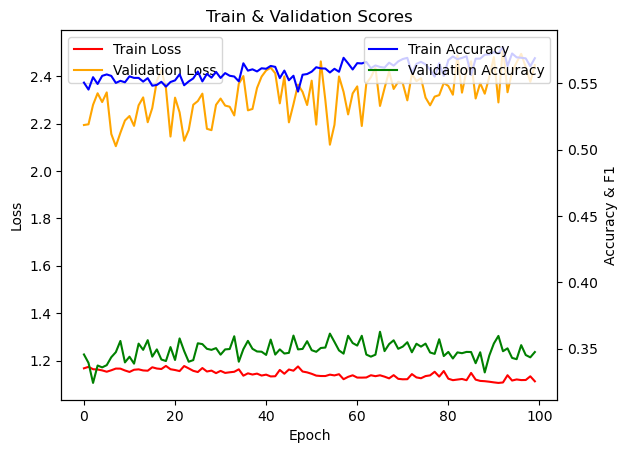

In [ ]:
grahp(relu_train_,relu_val_)

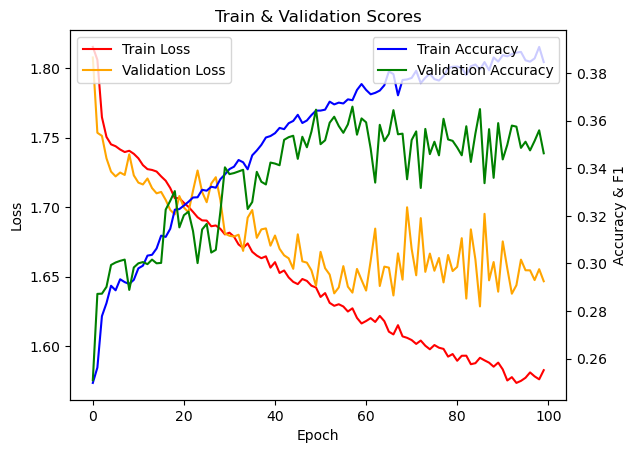

In [ ]:
grahp(tanh_train_,tanh_val_)

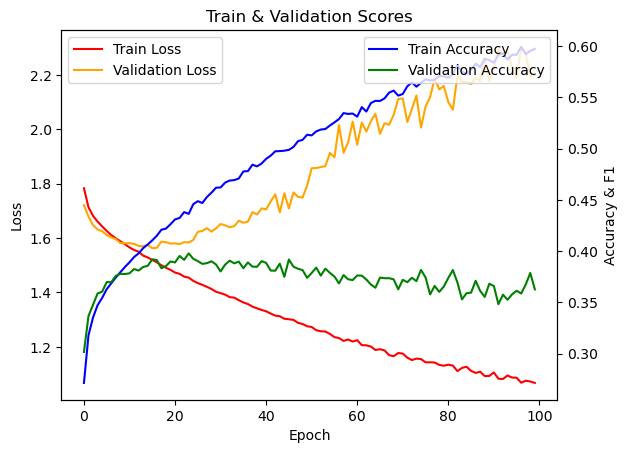

In [ ]:
grahp(leaky_train_,leaky_val_)

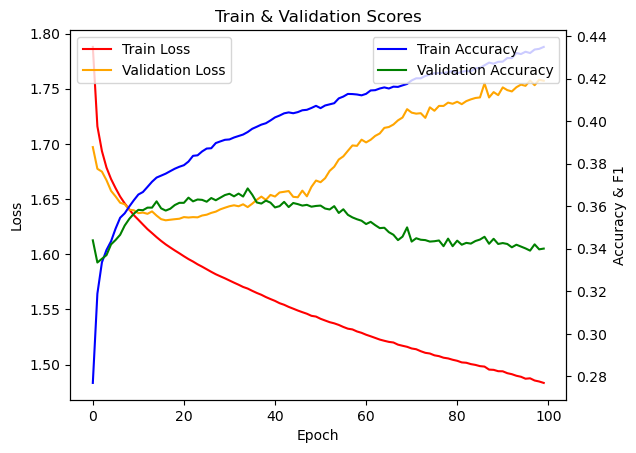

In [ ]:
grahp(soft_train_,soft_val_)

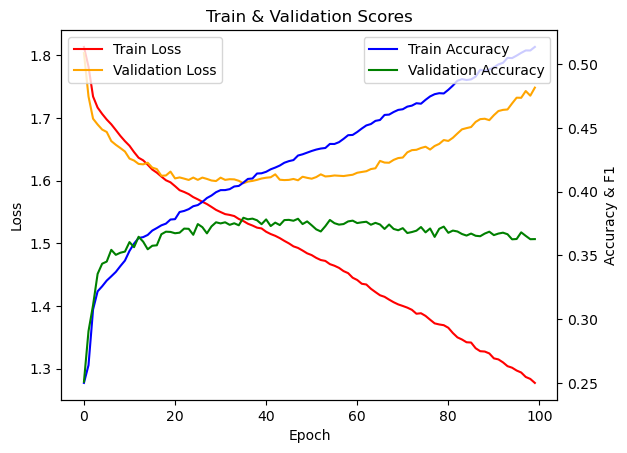

In [ ]:
grahp(sig_train_,sig_val_)

In [ ]:
import random

x_test = np.array(img_test) / 255.
x_test = x_test.reshape((-1, 48 * 48))
target_test = np.array(target_test)
data = np.concatenate([x_test, target_test.reshape(-1, 1)], axis=1)

In [ ]:
np.random.shuffle(data)

In [ ]:
testDS = DLdataset(data[:, :-1], data[:, -1])

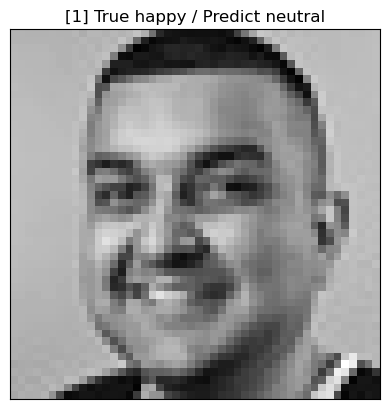

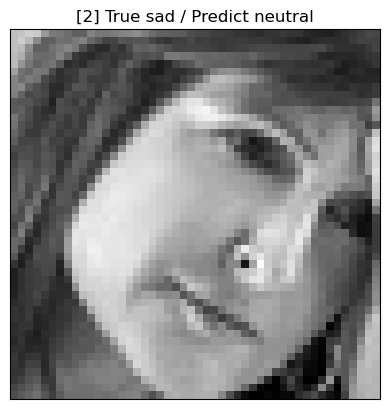

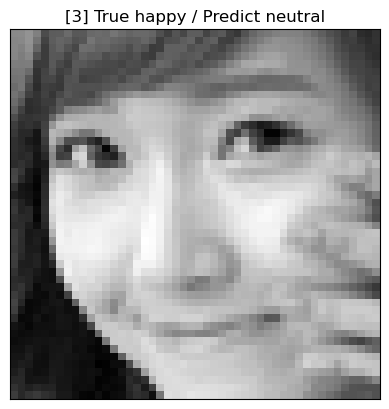

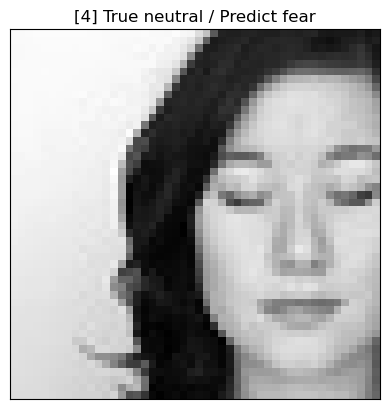

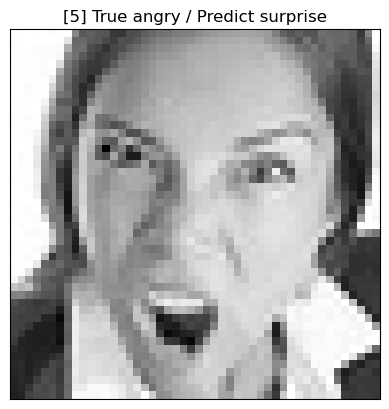

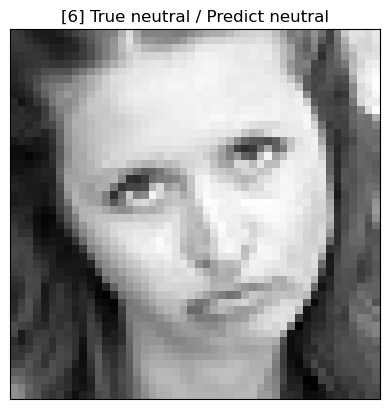

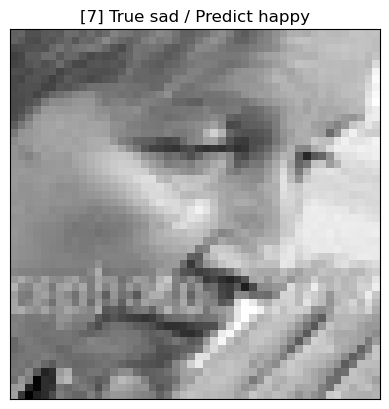

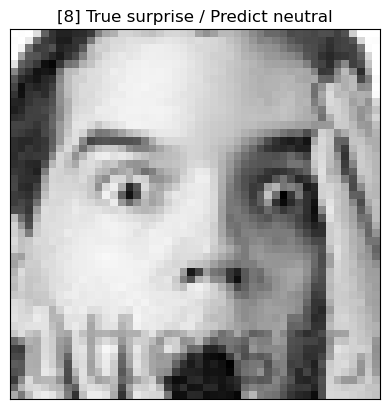

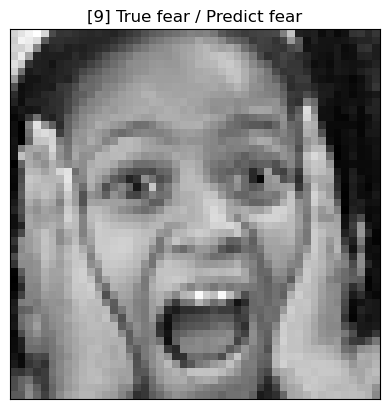

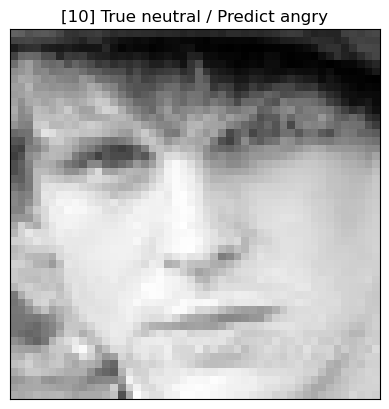

Accuracy: 0.45, Correct : 12827, Total : 28709


0.44679368839040023

In [ ]:
predicting(testDS,10,relu_model,'relu_model.pth')

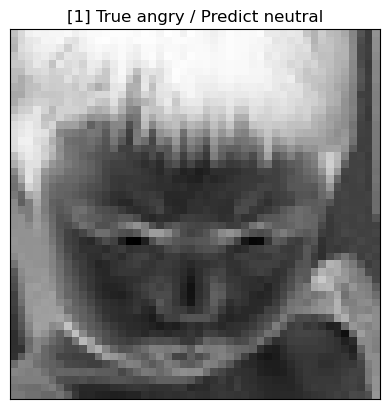

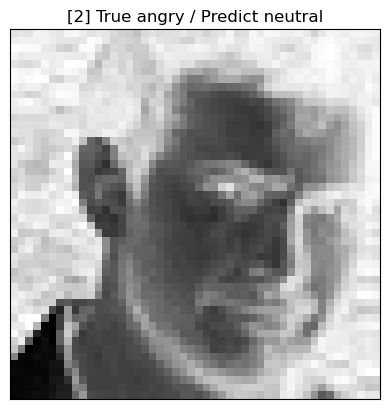

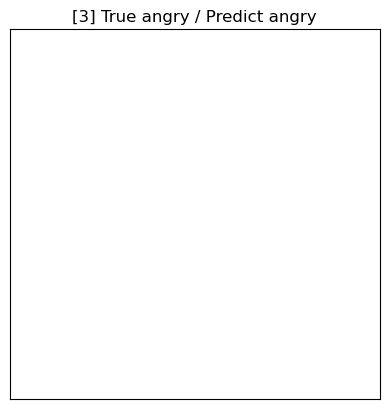

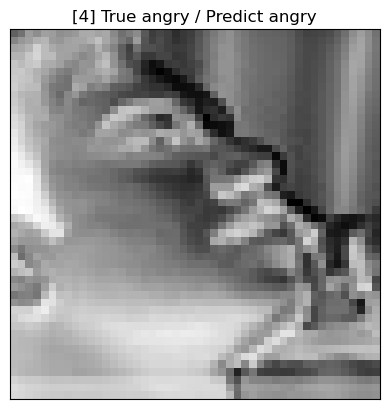

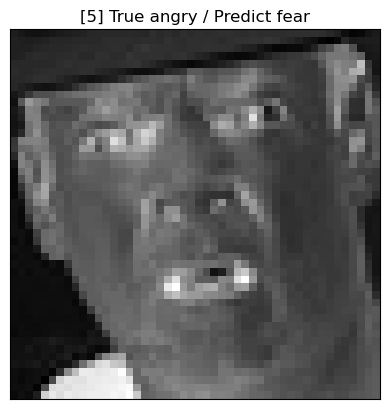

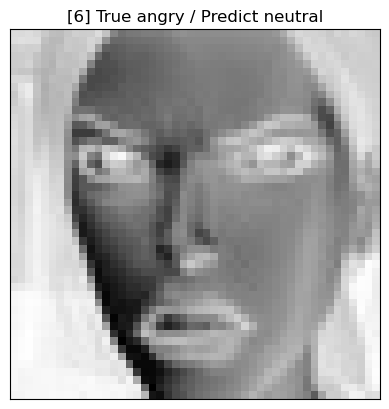

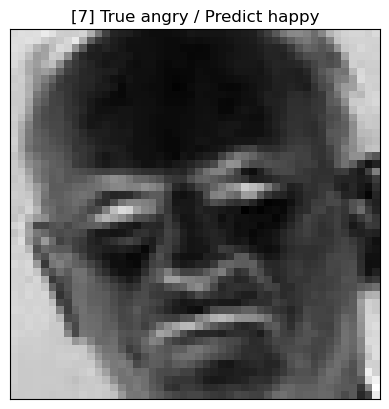

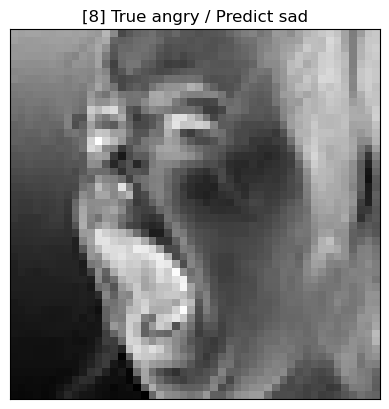

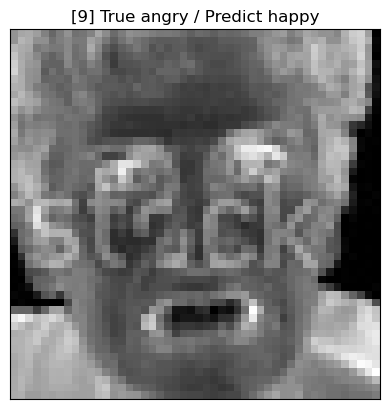

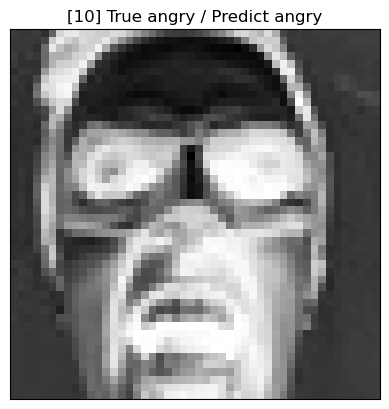

Accuracy: 0.40, Correct : 11501, Total : 28709


0.4006060817165349

In [ ]:
predicting(testDS, 10, sig_model, 'sig_model.pth')

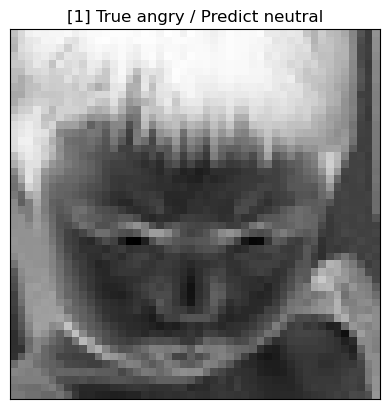

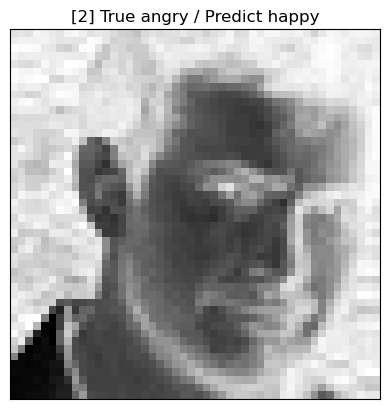

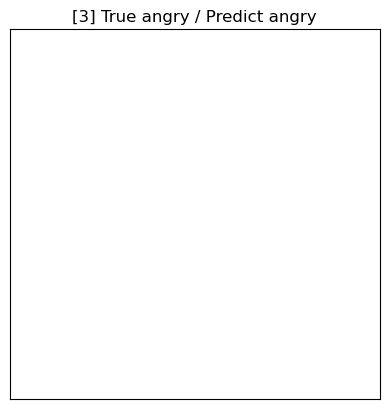

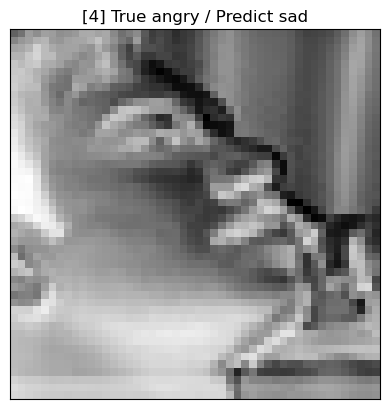

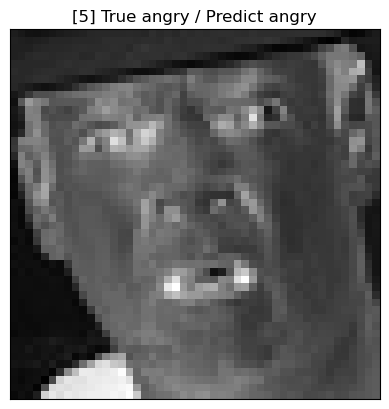

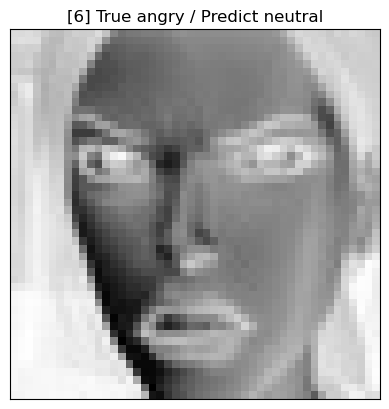

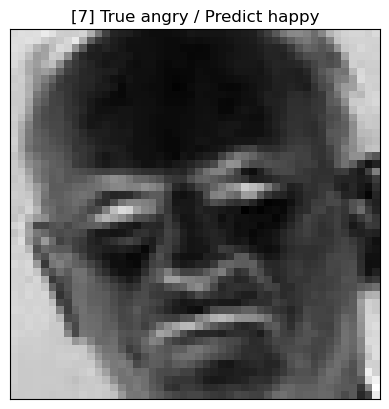

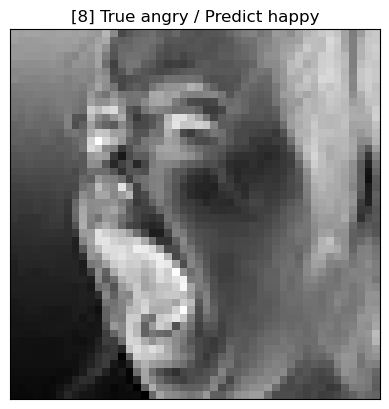

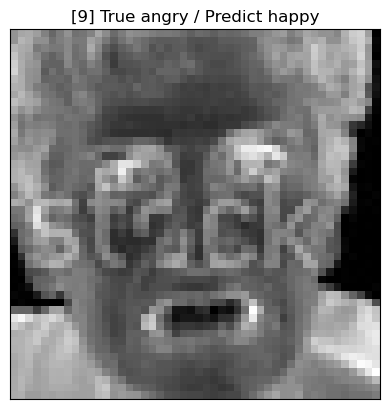

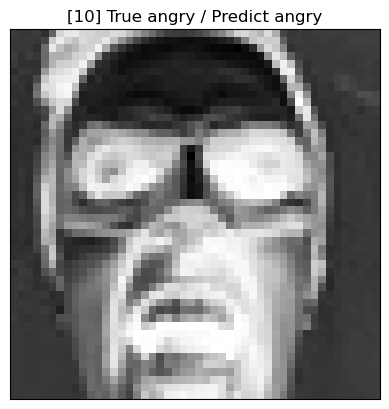

Accuracy: 0.39, Correct : 11146, Total : 28709


0.38824062140792087

In [ ]:
predicting(testDS, 10, tanh_model, 'tanh_model.pth')

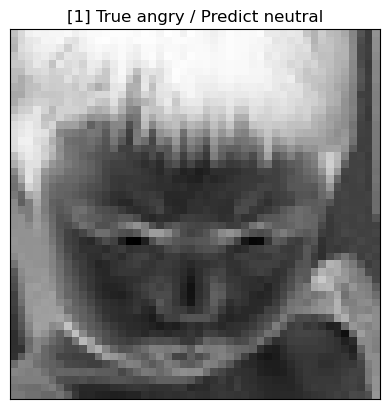

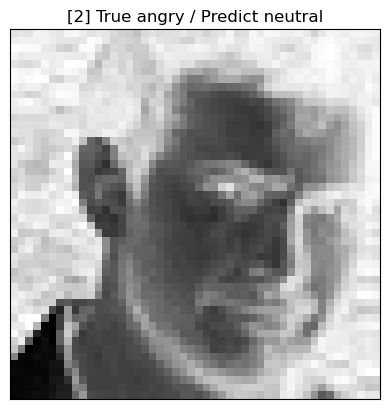

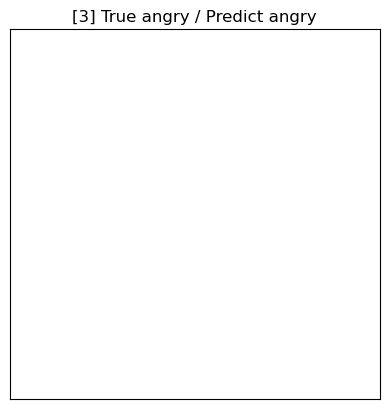

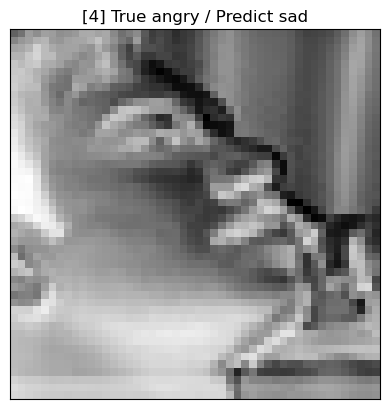

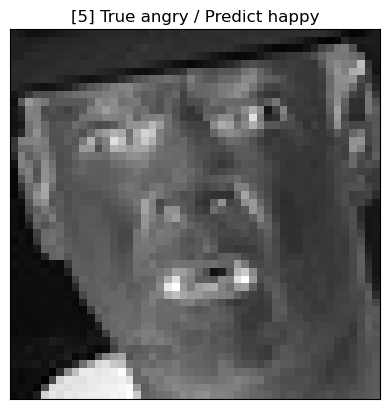

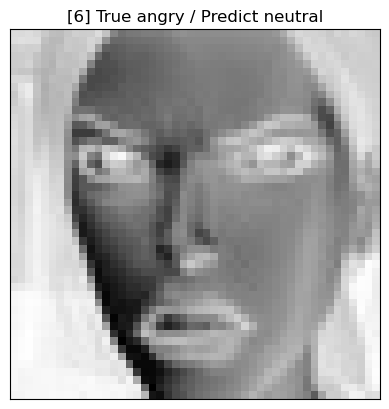

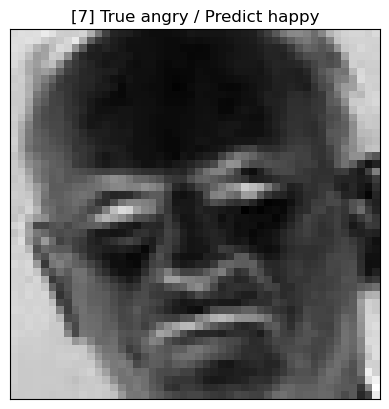

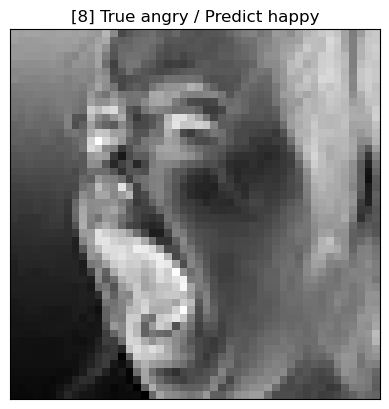

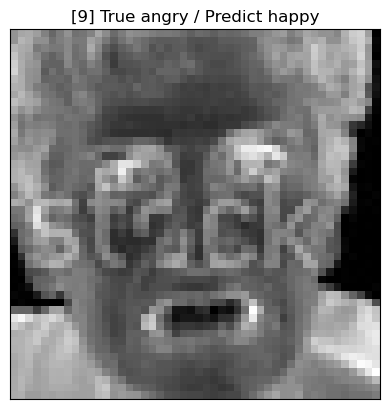

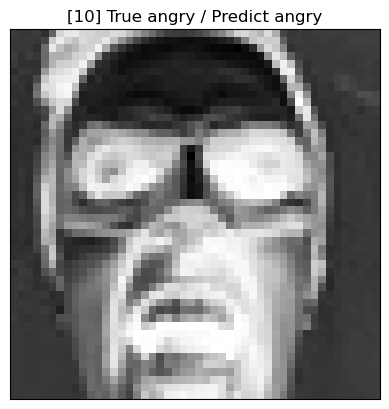

Accuracy: 0.41, Correct : 11840, Total : 28709


0.41241422550419726

In [ ]:
predicting(testDS, 10, leaky_model, 'leaky_model.pth')

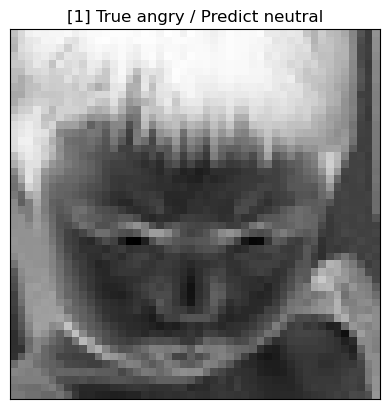

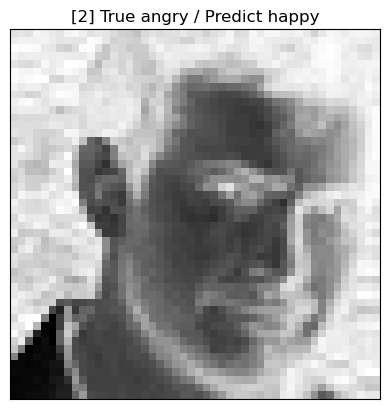

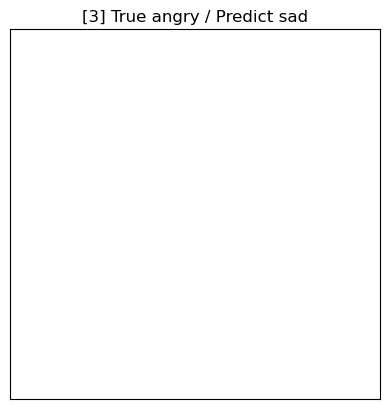

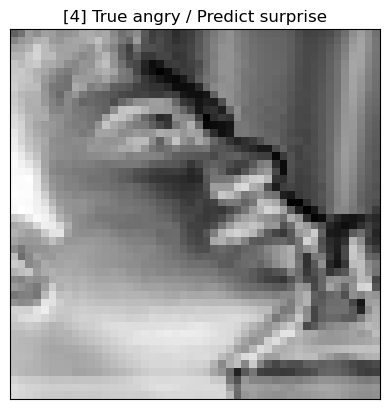

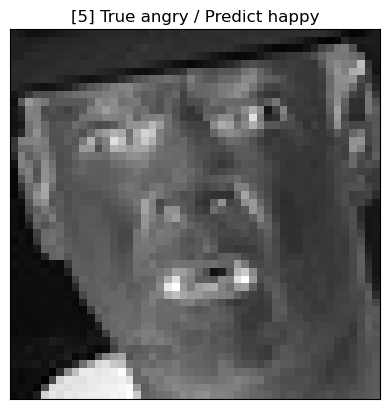

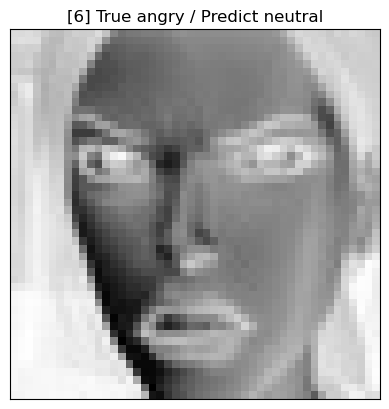

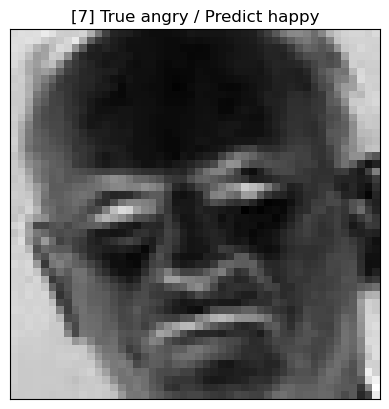

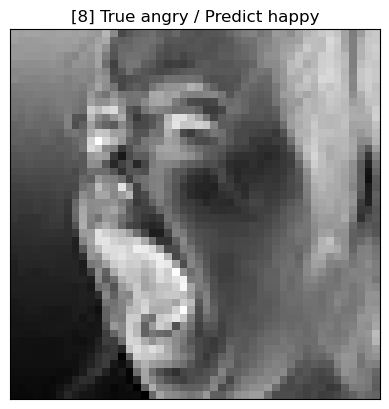

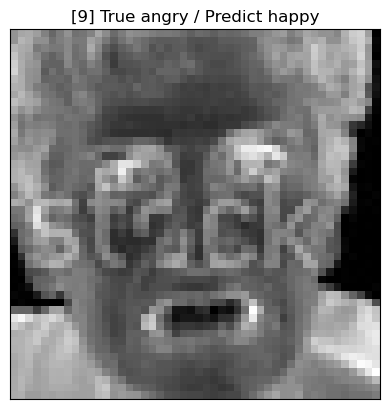

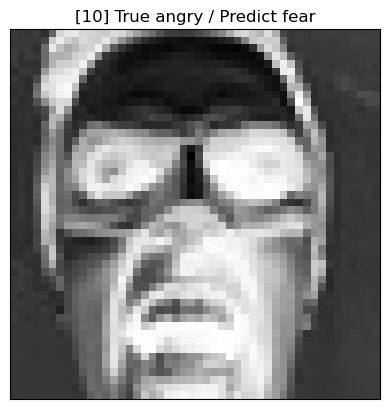

Accuracy: 0.37, Correct : 10682, Total : 28709


0.37207844230032394

In [ ]:
predicting(testDS, 10, soft_model, 'soft_model.pth')

In [ ]:
# 몀모마
# 이미지 불러오기
image_path = "data/test_m/KakaoTalk_20240313_130606893.png"
image = Image.open(image_path)
image = image.convert("L")

In [ ]:
resize = transforms.Resize((48, 48))
image = resize(image)

In [ ]:
image = np.array(image) / 255.

In [ ]:
image = image.reshape(-1,48*48)

In [ ]:
image = torch.FloatTensor(image)

In [ ]:
image

tensor([[0.1176, 0.1255, 0.1294,  ..., 0.4235, 0.4078, 0.3843]])

In [ ]:
label = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

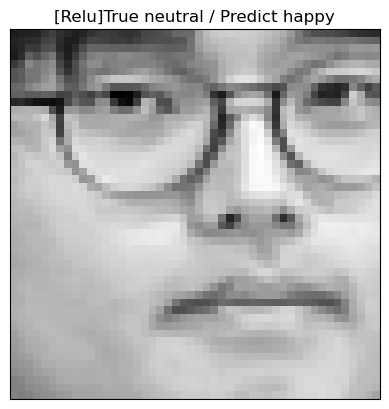

In [ ]:
plt.imshow(image.numpy().reshape(48, 48), cmap='gray')
plt.title(f'[Relu]True neutral / Predict {label[relu_model(image).argmax(dim = 1).item()]}')
plt.xticks([])
plt.yticks([])
plt.show()

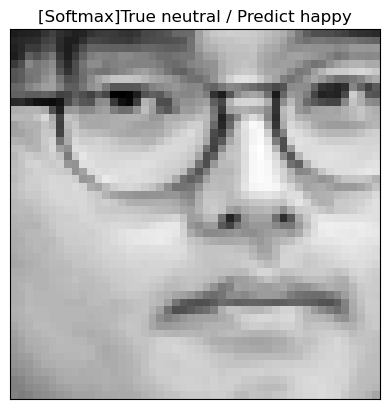

In [ ]:
plt.imshow(image.numpy().reshape(48, 48), cmap='gray')
plt.title(f'[Softmax]True neutral / Predict {label[soft_model(image).argmax(dim = 1).item()]}')
plt.xticks([])
plt.yticks([])
plt.show()

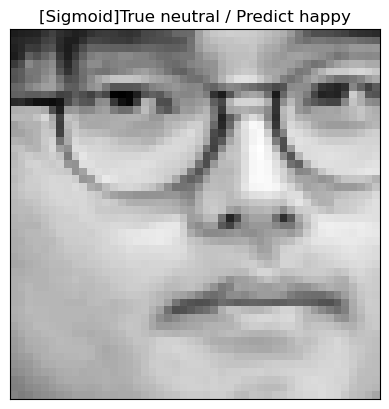

In [ ]:
plt.imshow(image.numpy().reshape(48, 48), cmap='gray')
plt.title(f'[Sigmoid]True neutral / Predict {label[sig_model(image).argmax(dim = 1).item()]}')
plt.xticks([])
plt.yticks([])
plt.show()

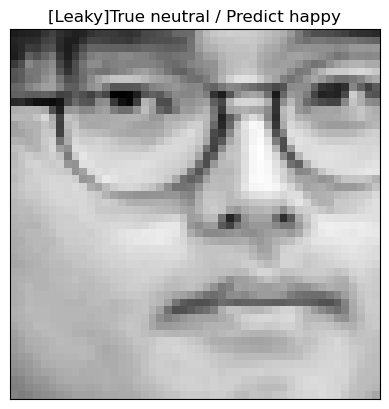

In [ ]:
plt.imshow(image.numpy().reshape(48, 48), cmap='gray')
plt.title(f'[Leaky]True neutral / Predict {label[leaky_model(image).argmax(dim = 1).item()]}')
plt.xticks([])
plt.yticks([])
plt.show()

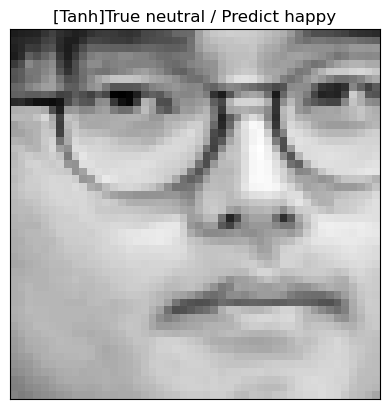

In [ ]:
plt.imshow(image.numpy().reshape(48, 48), cmap='gray')
plt.title(f'[Tanh]True neutral / Predict {label[tanh_model(image).argmax(dim = 1).item()]}')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# 모델 클래스 정의
class total_Model(nn.Module):
    
    def __init__(self, in_dim, out_dim, hidden_dims):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dims = hidden_dims  # 은닉층의 차원들을 담은 리스트
        self.layers = nn.ModuleList()   # 모듈을 담는 리스트
        
        prev_dim = self.in_dim
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, self.out_dim))
        self.relu = nn.ReLU()
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.relu(layer(x)) # 은닉층 계산하고 바로 AF 계산
        x = self.layers[-1](x)
        return x

In [ ]:
import torch
  # 사용자 정의 모델 클래스

model = total_Model(48*48,7,[512,256])
state_dict = torch.load('model/Adagrad total my_trained_model.pth')
model.load_state_dict(state_dict, strict=False)
model.eval()  # 추론 모드로 설정

# 추론 수행
with torch.no_grad():
    output = model(image)

# 출력값에서 가장 높은 확률을 가진 클래스 인덱스 확인
_, predicted = torch.max(output, 1)

RuntimeError: Error(s) in loading state_dict for total_Model:
	size mismatch for layers.0.weight: copying a param with shape torch.Size([500, 2304]) from checkpoint, the shape in current model is torch.Size([512, 2304]).
	size mismatch for layers.0.bias: copying a param with shape torch.Size([500]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layers.2.weight: copying a param with shape torch.Size([550, 500]) from checkpoint, the shape in current model is torch.Size([7, 256]).
	size mismatch for layers.2.bias: copying a param with shape torch.Size([550]) from checkpoint, the shape in current model is torch.Size([7]).